# Tutorial 2: Training a spiking neural network on a simple vision dataset

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see:
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

In Tutorial 1, we have seen how to train a simple multi-layer spiking neural network on a small synthetic dataset. In this tutorial, we will apply what we have learned so far to a slightly larger dataset.
Concretely, we will use the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

In [110]:
# !pip install tonic

In [111]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [112]:
torch.__version__

'2.6.0'

In [113]:
# The coarse network structure is dicated by the Fashion MNIST dataset.
nb_inputs  = 34*34 # https://greg-cohen.com/project/datasets/
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-3
nb_steps  = 100

batch_size = 20

In [114]:
torch.backends.mps.is_available()

True

In [115]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [116]:
## Load in the N-MNIST dataset
import tonic

train_dataset = tonic.datasets.NMNIST(save_to='./data', train=True, transform=None, target_transform=None)
test_dataset = tonic.datasets.NMNIST(save_to='./data', train=False, transform=None, target_transform=None)

In [117]:
train_dataset[0]

(array([(10, 30,    937, 1), (33, 20,   1030, 1), (12, 27,   1052, 1), ...,
        ( 7, 15, 302706, 1), (26, 11, 303852, 1), (11, 17, 305341, 1)],
       dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')]),
 0)

In [118]:
# sample = train_dataset[0]
# print(sample)


In [119]:
import torch.nn.functional as F

def preprocess_spike_events(spike_events, nb_steps=nb_steps, nb_units=nb_inputs, time_step=time_step):
    """
    Convert spike events into a binned spike train.

    Args:
        spike_events: Structured NumPy array of spike events (x, y, t, p).
        nb_steps: Number of time steps to bin the spikes into.
        nb_units: Number of neurons (x * y resolution).

    Returns:
        A binned spike train of shape (nb_steps, nb_units).
    """
    spike_train = np.zeros((nb_steps, nb_units), dtype=np.float32)
    for x, y, t, p in spike_events:
        if p == 1:  # Only process the event if p indicates a spike
            time_bin = int(t * time_step)  # Convert time to timestep
            if time_bin < nb_steps:
                neuron_id = x + y * int(np.sqrt(nb_inputs))  # Flatten 2D coordinates into 1D neuron ID
                spike_train[time_bin, neuron_id] += 1

    return torch.tensor(spike_train, dtype=torch.float32)

def custom_collate_fn(batch, num_classes=10):
    """
    Custom collate function to handle structured data and one-hot encode the labels.

    Args:
        batch: A list of samples (spike_events, label).
        num_classes: Number of classes for one-hot encoding.

    Returns:
        A tuple (spike_tensors, one_hot_labels).
    """
    spike_tensors = []
    labels = []

    for spike_events, label in batch:
        # Preprocess spike events
        spike_tensor = preprocess_spike_events(spike_events)
        spike_tensors.append(spike_tensor)

        # One-hot encode the label
        one_hot_label = F.one_hot(torch.tensor(label, dtype=torch.int64), num_classes=num_classes)
        labels.append(one_hot_label)

    # Stack spike tensors and labels into batches
    spike_tensors = torch.stack(spike_tensors)
    labels = torch.stack(labels)  # Convert list of one-hot labels into a batch
    return spike_tensors, labels


In [120]:
# REDO - get the representative split for the subset retrieval

def get_representative_subset_indices(data, limit, num_inputs = 10):
    """
    Selects a representative subset of data point indices for PyTorch Subset,
    using the number of unique labels as the number of representatives.

    Args:
        labels (np.ndarray or list): Array/list of labels for each data point.

    Returns:
        torch.Tensor: Tensor of indices of the selected representative data points.
    """

    num_representatives = len(data)  # Use number of unique labels

    representatives_per_class = num_representatives//num_inputs
    sample_per_class = limit // num_inputs
    selected_indices = []
    for i in range(num_inputs):
        range_v = np.arange(i*representatives_per_class, (i+1)*representatives_per_class)
        selected_indices.extend(np.random.choice(range_v, sample_per_class, replace=False))
        # selected_indices.append(np.random.choice(indices, 1, replace=False).item()) #ensure only one item is selected.

    return torch.tensor(selected_indices)


In [121]:
from torch.utils.data import DataLoader, Subset

train_limit = 100
test_limit = 100
# train_dataset = test_dataset
train_subset_indices = get_representative_subset_indices(train_dataset, train_limit)
test_subset_indices = get_representative_subset_indices(test_dataset, test_limit)

train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_subset_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,  # Use the custom collate function
    # num_workers=4,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,  # Use the custom collate function
    # num_workers=4,
    pin_memory=True,
    drop_last=True
)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# nb_steps = train_dataset[0][0].shape[0] # Get the number of time steps
nb_inputs = 34 * 34

In [122]:
train_subset[0]

(array([(21,  9,   1564, 0), (12,  4,   3864, 1), (12, 13,   4013, 0), ...,
        (30,  5, 304817, 1), (27, 13, 307282, 1), (28, 17, 308085, 1)],
       dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')]),
 0)

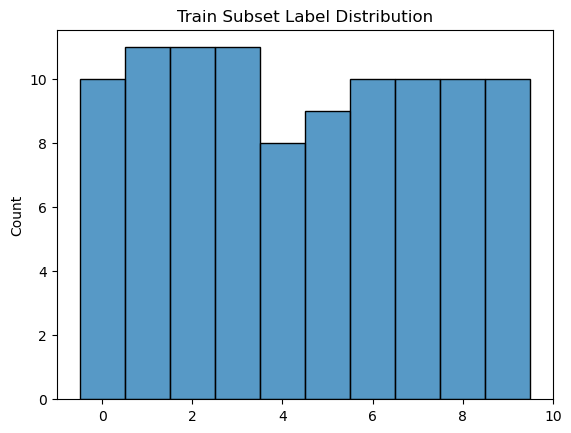

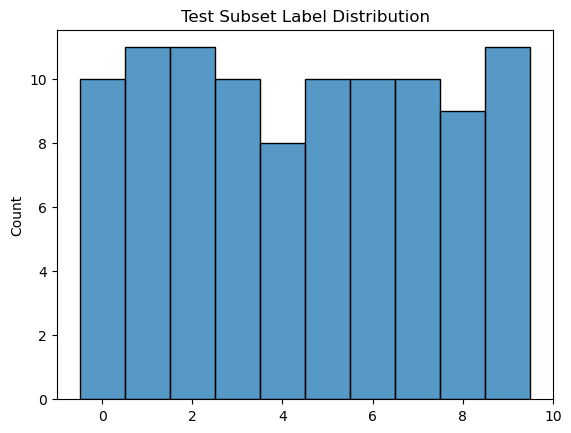

In [123]:
# Check distribution for each subset using train_loader.dataset[i][1]
train_labels = [train_loader.dataset[i][1] for i in range(len(train_loader.dataset))]
test_labels = [test_loader.dataset[i][1] for i in range(len(test_loader.dataset))]
sns.histplot(train_labels, discrete=True)
plt.title('Train Subset Label Distribution')
plt.show()
sns.histplot(test_labels, discrete=True)
plt.title('Test Subset Label Distribution')
plt.show()

In [124]:
print(len(train_loader))

5


Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

### Setup of the spiking network model

In [125]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [126]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [127]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

We can now run this code and plot the output layer "membrane potentials" below. As desired, these potentials do not have spikes riding on them.

## Training the network

In [128]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [129]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset
        # print(f"h1[:, t] shape: {h1[:, t].shape}")
        # print(f"syn shape: {syn.shape}")

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [130]:
from tqdm import tqdm  # Import tqdm

import torch.optim as optim

def train(train_loader, lr=2e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []

    # scaler = torch.amp.GradScaler(device=device) if device.type == 'cuda' else None

    for e in range(nb_epochs):
        local_loss = []
        with tqdm(train_loader, desc=f"Epoch {e+1}/{nb_epochs}", unit="batch") as t:
            for x_local, y_local in t:
                x_local = x_local.to(device)
                y_local = y_local.to(device)

                # print(f"Input dimensions: x_local.shape = {x_local.shape}, y_local.shape = {y_local.shape}")

                # # with torch.amp.autocast(device_type=device.type, enabled=(scaler is not None)):  # Mixed Precision

                #     print(f"Output dimensions: output.shape = {output.shape}")

                output, _ = run_snn(x_local)  # Assuming run_snn() is integrated into model
                log_p_y = log_softmax_fn(output)  # LogSoftmax across all classes
                loss_val = loss_fn(log_p_y, y_local)

                # Backward pass
                # if scaler:  # Mixed precision handling
                #     scaler.scale(loss_val).backward()
                #     scaler.step(optimizer)
                #     scaler.update()
                # else:
                loss_val.backward()
                optimizer.step()

                t.set_postfix(loss=loss_val.item())

                local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)

    return loss_hist

from sklearn.metrics import confusion_matrix

def compute_classification_accuracy(data_loader):
    """ 
    Computes classification accuracy and confusion matrix on supplied data in batches.
    
    Returns:
        accuracy: Overall classification accuracy.
        conf_matrix: Confusion matrix of shape (num_classes, num_classes).
    """
    accs = []
    all_preds = []
    all_labels = []

    for x_local, y_local in data_loader:
        # Move data to the appropriate device
        x_local, y_local = x_local.to(device), y_local.to(device)

        # Run the SNN model
        output, _ = run_snn(x_local)

        # Compute predictions
        m, _ = torch.max(output, 1)  # Max over time
        _, preds = torch.max(m, 1)   # Argmax over output units

        # Convert one-hot encoded labels to class indices
        y_local_indices = torch.argmax(y_local, 1)  # Shape: [batch_size]

        # Compute accuracy for the current batch
        correct = (y_local_indices == preds).float()  # Shape: [batch_size]
        tmp = correct.mean().item()  # Accuracy for the current batch
        accs.append(tmp)

        # Store predictions and labels for the confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_local_indices.cpu().numpy())

    # Compute overall accuracy
    accuracy = np.mean(accs)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, conf_matrix

In [131]:
loss_hist = train(train_loader, lr=2e-4, nb_epochs=30)

Epoch 1/30: 100%|██████████| 5/5 [00:02<00:00,  2.17batch/s, loss=4.39]


Epoch 1: loss=4.69723


Epoch 2/30: 100%|██████████| 5/5 [00:02<00:00,  2.29batch/s, loss=3.88]


Epoch 2: loss=4.04307


Epoch 3/30: 100%|██████████| 5/5 [00:02<00:00,  2.22batch/s, loss=3.62]


Epoch 3: loss=3.73534


Epoch 4/30: 100%|██████████| 5/5 [00:02<00:00,  2.32batch/s, loss=3.47]


Epoch 4: loss=3.55812


Epoch 5/30: 100%|██████████| 5/5 [00:02<00:00,  2.39batch/s, loss=3.4] 


Epoch 5: loss=3.44053


Epoch 6/30: 100%|██████████| 5/5 [00:02<00:00,  2.39batch/s, loss=3.3] 


Epoch 6: loss=3.35984


Epoch 7/30: 100%|██████████| 5/5 [00:02<00:00,  2.24batch/s, loss=3.33]


Epoch 7: loss=3.29501


Epoch 8/30: 100%|██████████| 5/5 [00:02<00:00,  2.36batch/s, loss=3.19]


Epoch 8: loss=3.24301


Epoch 9/30: 100%|██████████| 5/5 [00:02<00:00,  2.27batch/s, loss=3.23]


Epoch 9: loss=3.19688


Epoch 10/30: 100%|██████████| 5/5 [00:02<00:00,  2.19batch/s, loss=3.15]


Epoch 10: loss=3.15566


Epoch 11/30: 100%|██████████| 5/5 [00:02<00:00,  2.19batch/s, loss=3.11]


Epoch 11: loss=3.11864


Epoch 12/30: 100%|██████████| 5/5 [00:02<00:00,  2.06batch/s, loss=3.1] 


Epoch 12: loss=3.08549


Epoch 13/30: 100%|██████████| 5/5 [00:02<00:00,  2.14batch/s, loss=3.09]


Epoch 13: loss=3.05493


Epoch 14/30: 100%|██████████| 5/5 [00:02<00:00,  2.32batch/s, loss=3.01]


Epoch 14: loss=3.02505


Epoch 15/30: 100%|██████████| 5/5 [00:02<00:00,  2.29batch/s, loss=2.96]


Epoch 15: loss=2.99751


Epoch 16/30: 100%|██████████| 5/5 [00:02<00:00,  2.38batch/s, loss=2.93]


Epoch 16: loss=2.97303


Epoch 17/30: 100%|██████████| 5/5 [00:02<00:00,  2.34batch/s, loss=2.94]


Epoch 17: loss=2.94756


Epoch 18/30: 100%|██████████| 5/5 [00:02<00:00,  2.35batch/s, loss=2.87]


Epoch 18: loss=2.92355


Epoch 19/30: 100%|██████████| 5/5 [00:02<00:00,  2.29batch/s, loss=2.84]


Epoch 19: loss=2.90044


Epoch 20/30: 100%|██████████| 5/5 [00:02<00:00,  2.04batch/s, loss=2.83]


Epoch 20: loss=2.88012


Epoch 21/30: 100%|██████████| 5/5 [00:02<00:00,  2.02batch/s, loss=2.84]


Epoch 21: loss=2.86001


Epoch 22/30: 100%|██████████| 5/5 [00:02<00:00,  2.26batch/s, loss=2.86]


Epoch 22: loss=2.84042


Epoch 23/30: 100%|██████████| 5/5 [00:02<00:00,  2.31batch/s, loss=2.83]


Epoch 23: loss=2.82221


Epoch 24/30: 100%|██████████| 5/5 [00:02<00:00,  2.28batch/s, loss=2.8] 


Epoch 24: loss=2.80612


Epoch 25/30: 100%|██████████| 5/5 [00:02<00:00,  2.24batch/s, loss=2.78]


Epoch 25: loss=2.79036


Epoch 26/30: 100%|██████████| 5/5 [00:02<00:00,  2.08batch/s, loss=2.78]


Epoch 26: loss=2.77377


Epoch 27/30: 100%|██████████| 5/5 [00:02<00:00,  2.16batch/s, loss=2.76]


Epoch 27: loss=2.75867


Epoch 28/30: 100%|██████████| 5/5 [00:02<00:00,  2.19batch/s, loss=2.77]


Epoch 28: loss=2.74434


Epoch 29/30: 100%|██████████| 5/5 [00:02<00:00,  2.33batch/s, loss=2.66]


Epoch 29: loss=2.73083


Epoch 30/30: 100%|██████████| 5/5 [00:02<00:00,  2.19batch/s, loss=2.73]

Epoch 30: loss=2.71722


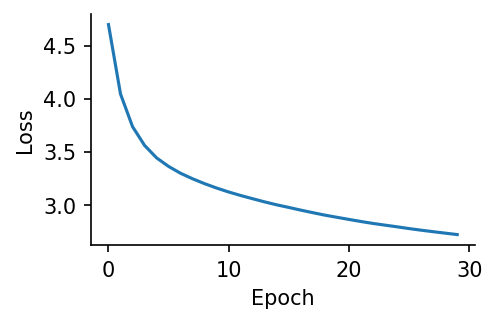

In [132]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [133]:
def plot_confusion_matrix(conf_matrix, class_names):
    """ Plots the confusion matrix. """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Train Accuracy: 8.00%


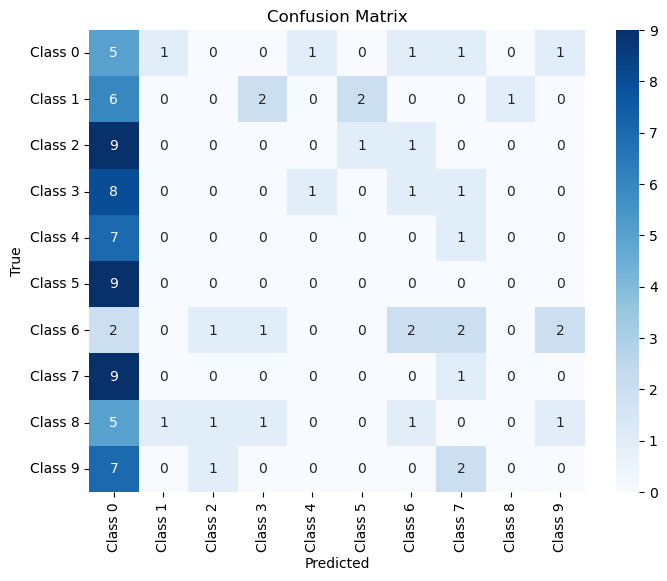

In [134]:
train_accuracy, train_conf_matrix = compute_classification_accuracy(train_loader)

# Print results
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(train_conf_matrix, class_names)


Test Accuracy: 10.00%


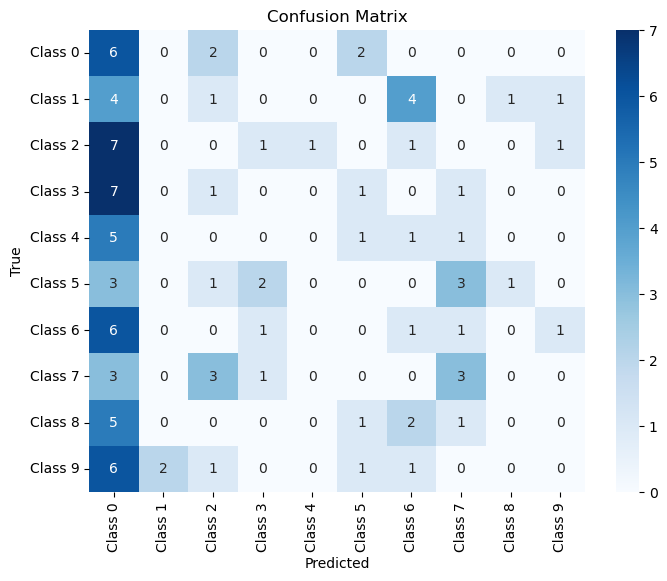

In [135]:
test_accuracy, test_conf_matrix = compute_classification_accuracy(test_loader)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(test_conf_matrix, class_names)


In [136]:
def get_mini_batch(data_loader, shuffle=False):
    for ret in data_loader:
        return ret

In [137]:
x_batch, y_batch = get_mini_batch(test_loader)
x_batch = x_batch.to(device)
output, other_recordings = run_snn(x_batch)
mem_rec, spk_rec = other_recordings

In [138]:
print("mem_rec shape:", mem_rec.shape)
print("spk_rec shape:", spk_rec.shape)

mem_rec shape: torch.Size([20, 100, 100])
spk_rec shape: torch.Size([20, 100, 100])


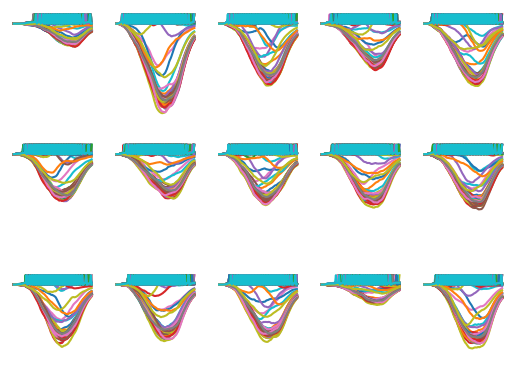

In [139]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

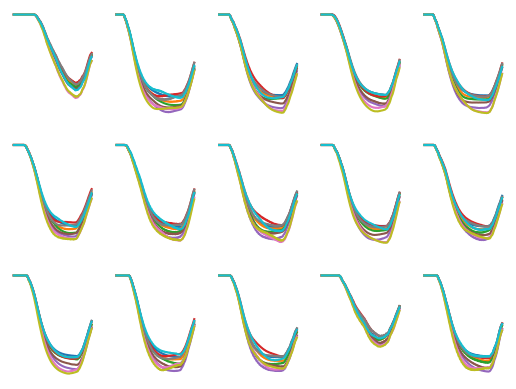

In [140]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

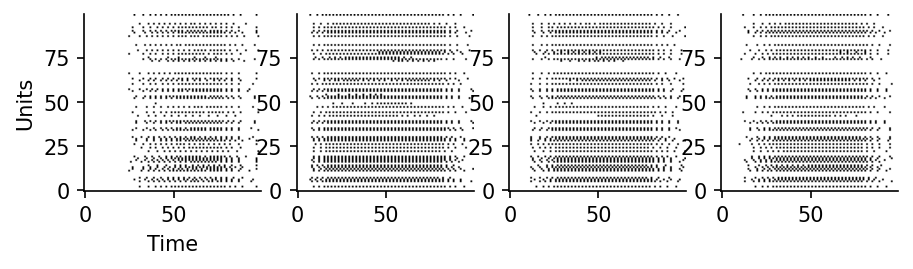

In [141]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

In conclusion, we see that already this simple spiking network solves the classification problem with ~85% accuracy, and there is plenty of room left for tweaking. However, the hidden layer activities do not look very biological. Although the network displays population sparseness in that only a subset of neurons are active at any given time, the individual neurons' firing rates are pathologically high. This pathology is not too surprising since we have not incentivized low activity levels in any way. We will create such an incentive to address this issue by activity regularization in one of the next tutorials.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.